In [81]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [82]:
df = pd.read_csv("training.csv")#.set_index("article_number")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9500 entries, 0 to 9499
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   article_number  9500 non-null   int64 
 1   article_words   9500 non-null   object
 2   topic           9500 non-null   object
dtypes: int64(1), object(2)
memory usage: 222.8+ KB


In [83]:
data = df[df.topic != "IRRELEVANT"].reset_index(drop=True)

## Some graphs about the number of words in each class

In [84]:
data['word_count'] = data.article_words.str.count(",")+1

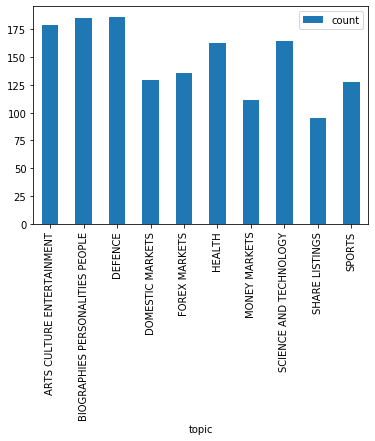

In [85]:
word_count_distribution = data.groupby("topic").word_count.mean().plot(kind="bar", label="count", legend="best")

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Text xticklabel objects>)

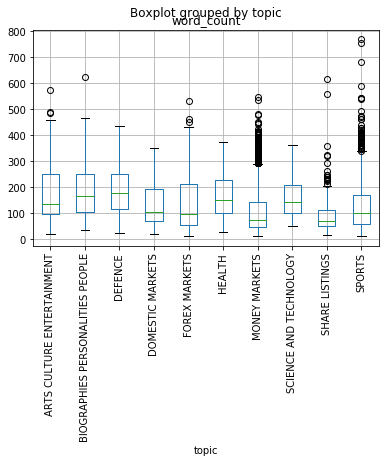

In [86]:
data.boxplot(column ='word_count',by ='topic')
plt.xticks(rotation=90)

## Counting the most frequent five words in each class

In [87]:
topic_group = data.groupby('topic')
most_frequent_word_list = {}
for name, group in topic_group :
    frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(5)
    most_frequent_word_list.update({name:frequent_words})


In [88]:
most_frequent_word_list


{'ARTS CULTURE ENTERTAINMENT': [('year', 156),
  ('film', 153),
  ('million', 102),
  ('stat', 83),
  ('work', 81)],
 'BIOGRAPHIES PERSONALITIES PEOPLE': [('year', 249),
  ('presid', 198),
  ('yeltsin', 140),
  ('stat', 133),
  ('hospit', 124)],
 'DEFENCE': [('nato', 511),
  ('stat', 410),
  ('milit', 406),
  ('forc', 381),
  ('defend', 357)],
 'DOMESTIC MARKETS': [('import', 541),
  ('ton', 324),
  ('percent', 265),
  ('year', 262),
  ('oil', 191)],
 'FOREX MARKETS': [('dollar', 3358),
  ('bank', 2178),
  ('rate', 1720),
  ('trad', 1671),
  ('market', 1662)],
 'HEALTH': [('year', 253),
  ('health', 245),
  ('stat', 241),
  ('diseas', 184),
  ('tobacc', 169)],
 'MONEY MARKETS': [('bank', 4447),
  ('rate', 3684),
  ('percent', 3515),
  ('dollar', 3387),
  ('market', 2890)],
 'SCIENCE AND TECHNOLOGY': [('spac', 141),
  ('mir', 110),
  ('shuttl', 83),
  ('scient', 77),
  ('year', 73)],
 'SHARE LISTINGS': [('shar', 740),
  ('compan', 391),
  ('list', 347),
  ('million', 295),
  ('stock', 2

## Yangqi's work Agenda 

### Feature engineering

1. Pure word count method (Yunze)

2. Pure TF-IDF method (Raymond) 

3. Word count method with threshold (min max) *convert to TF-IDF*

4. Key words word count (top 10 in each group) give you 100 words *convert to TF-IDF*

### SVM 

1. build easy svm model 
    1. Train the model 
    2. Develop the model 
    3. Accuracy measure 
    4. Fit the test set
    5. Accuracy measure and recommendation 

2. SVM with grid search


3. SVM to classify irrelevant and relevant 


### Recommendation step

In [89]:
import warnings

import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import cross_val_score # get a specific score of a model using CV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # a list of english stop words
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.exceptions import ConvergenceWarning

In [90]:
train_x_ori = df.article_words

In [92]:
vect = CountVectorizer().fit(train_x_ori)
print(f"vocabulary size: {len(vect.vocabulary_)}")
features = vect.get_feature_names()
#print(f"The top 20 most frequent words:\n{features[:20]}")
#print("\nFeatures 20010 to 20030:\n{}".format(features[20010:20030]))
#print("\nEvery 2000th feature:\n{}".format(features[::2000]))

vocabulary size: 35822


**count vector features w/ min max df**

In [93]:
train_x_wc = vect.transform(train_x_ori)
print(train_x_wc.shape) #first features 

(9500, 35822)


In [94]:
vect_min = CountVectorizer(min_df=5).fit(train_x_ori)
train_x_wc_min = vect_min.transform(train_x_ori)
print(train_x_wc_min.shape) #second features, with minimum word frequent as 5 


(9500, 9495)


In [95]:
sum_words = train_x_wc_min.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vect_min.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [96]:
print(f"The top 20 most frequent words:\n{words_freq[:20]}")
print(f"The top 20 most infrequent words:\n{words_freq[-20:]}")

The top 20 most frequent words:
[('percent', 11610), ('bank', 9937), ('year', 9241), ('market', 8571), ('trad', 8446), ('rate', 7931), ('dollar', 7576), ('million', 7034), ('stat', 5162), ('cent', 4987), ('deal', 4795), ('shar', 4712), ('month', 4580), ('day', 4526), ('week', 4372), ('high', 4299), ('compan', 4041), ('pric', 3888), ('expect', 3877), ('clos', 3860)]
The top 20 most infrequent words:
[('livel', 5), ('renown', 5), ('indemn', 5), ('underneath', 5), ('cousin', 5), ('eek', 5), ('potat', 5), ('downs', 5), ('velli', 5), ('ilan', 5), ('and', 5), ('catherwood', 5), ('sandon', 5), ('dagmar', 5), ('retribut', 5), ('windy', 5), ('brow', 5), ('babel', 5), ('manager', 5), ('ventil', 5)]


In [97]:
train_x_wc_max = CountVectorizer(max_df=500).fit(train_x_ori).transform(train_x_ori)
print(train_x_wc_max.shape)

(9500, 35519)


**tf-idf features w/ min max df**

In [98]:
train_x_tf = TfidfVectorizer().fit_transform(train_x_ori)
print(train_x_tf.shape)

(9500, 35822)


In [99]:
train_x_tf_min = TfidfVectorizer(min_df=5).fit_transform(train_x_ori)
print(train_x_tf_min.shape)

(9500, 9495)


In [100]:
train_x_tf_max = TfidfVectorizer(max_df=500).fit_transform(train_x_ori)
print(train_x_tf_max.shape)

(9500, 35519)


**Key words methods**

In [101]:
topic_group = df.groupby('topic')
most_frequent_word_list = {}
for name, group in topic_group :
    frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(5)
    most_frequent_word_list.update({name:frequent_words})

In [102]:
most_frequent_word_list #show the most frequent words

{'ARTS CULTURE ENTERTAINMENT': [('year', 156),
  ('film', 153),
  ('million', 102),
  ('stat', 83),
  ('work', 81)],
 'BIOGRAPHIES PERSONALITIES PEOPLE': [('year', 249),
  ('presid', 198),
  ('yeltsin', 140),
  ('stat', 133),
  ('hospit', 124)],
 'DEFENCE': [('nato', 511),
  ('stat', 410),
  ('milit', 406),
  ('forc', 381),
  ('defend', 357)],
 'DOMESTIC MARKETS': [('import', 541),
  ('ton', 324),
  ('percent', 265),
  ('year', 262),
  ('oil', 191)],
 'FOREX MARKETS': [('dollar', 3358),
  ('bank', 2178),
  ('rate', 1720),
  ('trad', 1671),
  ('market', 1662)],
 'HEALTH': [('year', 253),
  ('health', 245),
  ('stat', 241),
  ('diseas', 184),
  ('tobacc', 169)],
 'IRRELEVANT': [('percent', 5945),
  ('year', 5237),
  ('million', 4738),
  ('trad', 3660),
  ('market', 3547)],
 'MONEY MARKETS': [('bank', 4447),
  ('rate', 3684),
  ('percent', 3515),
  ('dollar', 3387),
  ('market', 2890)],
 'SCIENCE AND TECHNOLOGY': [('spac', 141),
  ('mir', 110),
  ('shuttl', 83),
  ('scient', 77),
  ('year

In [103]:
word_list_5 = [] #the most 5 frequent words in each topic 
for name, group in topic_group :
    frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(5)
    common_words = [i[0] for i in frequent_words]
    word_list_5 = word_list_5 + common_words

In [104]:
print(word_list_5)
word_list_arts = [i for i in word_list_5[:5] if word_list_5.count(i) == 1] # the words that is unique and high frequent on topic 1 (arts)

['year', 'film', 'million', 'stat', 'work', 'year', 'presid', 'yeltsin', 'stat', 'hospit', 'nato', 'stat', 'milit', 'forc', 'defend', 'import', 'ton', 'percent', 'year', 'oil', 'dollar', 'bank', 'rate', 'trad', 'market', 'year', 'health', 'stat', 'diseas', 'tobacc', 'percent', 'year', 'million', 'trad', 'market', 'bank', 'rate', 'percent', 'dollar', 'market', 'spac', 'mir', 'shuttl', 'scient', 'year', 'shar', 'compan', 'list', 'million', 'stock', 'play', 'win', 'game', 'year', 'match']


In [105]:
word_list_arts

['film', 'work']

In [106]:
occurence_df = pd.DataFrame() #show their occurence in other topics 
for words in word_list_arts:
    occurence_dict = {}
    for name, group in topic_group :
        word_counter = Counter(" ".join(group["article_words"]).split(","))
        occurence = word_counter[words]
        avg_occurence = occurence / len(group)
        occurence_dict.update({name:avg_occurence})
    occur_series = pd.Series(occurence_dict) 
    occur_series.name = words
    occurence_df = occurence_df.append(occur_series, ignore_index = True)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 8 Text xticklabel objects>)

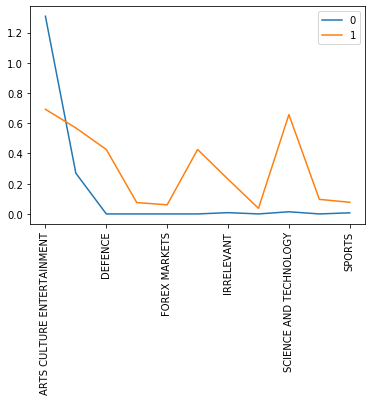

In [107]:
occurence_df.T.plot()
plt.xticks(rotation=90)